<a href="https://colab.research.google.com/github/ashishthomaschempolil/Santander-Customer-Satisfaction/blob/master/modelling_logTransformed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='muted',style='whitegrid')
import sklearn
from sklearn import metrics,ensemble,model_selection,linear_model,tree,calibration
import xgboost as xgb
import lightgbm as lgb
import scipy
import random
from tqdm import tqdm
import os
np.random.seed(13154)

In [4]:
file = [k for k in os.listdir('/content/drive/My Drive/Santander_Customer_Satisfaction') if (('train' in k)|('test' in k))&('X' not in k)] #getting all the necessary files for modelling
file

['train_Normal.pkl',
 'test_Normal.pkl',
 'train_Normal with Response encoding.pkl',
 'test_Normal with Response encoding.pkl',
 'train_Normal with One Hot Encoding.pkl',
 'test_Normal with One Hot Encoding.pkl',
 'train_Log Transformed.pkl',
 'test_Log Transformed.pkl',
 'train_Log Transformed with Response encoding.pkl',
 'test_Log Transformed with Response encoding.pkl',
 'train_Log Transformed with One Hot Encoding.pkl',
 'test_Log Transformed with One Hot Encoding.pkl']

In [5]:
file_path = '/content/drive/My Drive/Santander_Customer_Satisfaction/'
train_file = file_path+file[6] #log transformed
test_file = file_path+file[7]
dataset= "Log Transformed"
train = pd.read_pickle(train_file)
test = pd.read_pickle(test_file)
X_train = train.drop(['ID','TARGET'],axis=1)
y_train = train['TARGET'].values
X_test = test.drop('ID',axis=1)
del train,test
X_train,X_val,y_train,y_val = model_selection.train_test_split(X_train,y_train,stratify=y_train,test_size=0.15)
X_train.shape,X_val.shape,X_test.shape

((64617, 358), (11403, 358), (75818, 358))

In [6]:
global i
i=0
def plot_auc(y_true,y_pred,label,dataset=dataset):
  """
  Plots auc curve when y_true and y_pred are given
  dataset is string which tells which dataset were used.
  label: tells which model was used
  If label is a list plots all the auc curve for all labels (here y_pred will be a list of lists )
  """
  
  
  if (type(label)!=list) & (type(label)!=np.array):
    print("\t\t %s on %s dataset \t\t \n"%(label,dataset))
    fpr,tpr,threshold = metrics.roc_curve(y_true,y_pred) #getting true positive rate, false positive rate
    auc = metrics.roc_auc_score(y_true,y_pred) #getting auc score
    log_loss = metrics.log_loss(y_true,y_pred) #getting logloss
    label_1 = label+' AUC=%.3f'%(auc)

    #plotting tpr vs fpr
    sns.lineplot(fpr,tpr,label=label_1)
    x=np.arange(0,1.1,0.1) #auc=0.5 line 
    sns.lineplot(x,x,label="AUC=0.5")
    plt.title("ROC on %s dataset"%(dataset))
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #legend box outside graph
    plt.show()
    print("The log loss and auc was found to be %.3f and %.3f for %s on %s dataset."%(log_loss,auc,label,dataset))
    #creating a dataframe of the result
    result_dict = {"Model":label,'Dataset':dataset,'log_loss':log_loss,'auc':auc}
    
    return pd.DataFrame(result_dict,index=[i])

  else:
    plt.figure(figsize=(12,8))
    for k,y in enumerate(y_pred):
      fpr,tpr,threshold = metrics.roc_curve(y_true,y)
      auc = metrics.roc_auc_score(y_true,y)
      label_ = label[k]+' AUC=%.3f'%(auc)
      #plotting tpr vs fpr
      sns.lineplot(fpr,tpr,label=label_)

    x=np.arange(0,1.1,0.1)
    sns.lineplot(x,x,label="AUC=0.5")
    plt.title("Combined ROC")
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #legend box outside graph
    plt.show()

In [7]:
def find_best_params(model,params,cv=10,n_jobs=-1,X_train=X_train):
  """
  Funcion which implements Random Seacrh CV and returns best model
  """
  random_cv = model_selection.RandomizedSearchCV(model,param_distributions=params,scoring='roc_auc',n_jobs=n_jobs,cv=cv,verbose=2)
  random_cv.fit(X_train,y_train)
  print("The best auc score was %.3f"%(random_cv.best_score_))
  print("The best params were: %s"%(random_cv.best_params_))
  return random_cv.best_estimator_

In [8]:
def plot_feature_importance(df,feat_imp,top=20,size=(6,6)):
    """
    getting most important top features if df and feature_importance array is passed
    """
    top_indices = np.argsort(feat_imp)[::-1][:top] #getting the indices with top feature importace
    most_important_feat = df.columns[top_indices] #getiing the columns names
    plt.figure(figsize=size)
    sns.barplot(x=feat_imp[top_indices],y=most_important_feat) #plotting feature importance 
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel("Feature names")
    plt.show()

In [9]:
def get_top_features(df,feat_imp,top=50):
  """
  gets the top features.
  if top is of integer dtype it will return top features,
  if top is between 0 and 1, it will return features that have at least feature importance value= top
  """
  if (top>0.)&(top<=1.): #getting the features that have feature importance value greater than top
    feature_to_consider = [1 if i>=top else 0 for i in feat_imp]
    most_important_feat = [i  for i,j in zip(df.columns,feature_to_consider) if (j==1)]#getiing the columns names
  else:
    top_indices = np.argsort(feat_imp)[::-1][:top] #getting the indices with top feature importace
    most_important_feat = df.columns[top_indices] #getiing the columns names
  return most_important_feat    

# Modeling

# Logistic Regression

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced')
params = {'penalty':['l2','l1'], 'C':[10.**i for i in np.arange(-3,3,1)], 
          'fit_intercept':[True,False] ,
          }


In [ ]:
%%time
find_best_params(model,params)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.7min finished


The best auc score was 0.799
The best params were: {'penalty': 'l2', 'fit_intercept': True, 'C': 0.001}
CPU times: user 8.52 s, sys: 1.22 s, total: 9.74 s
Wall time: 3min 48s


LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [10]:
model = linear_model.LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=10, penalty='l2',
                  solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

model.fit(X_train,y_train)

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=10, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

		 Logisic Regression on Log Transformed dataset 		 



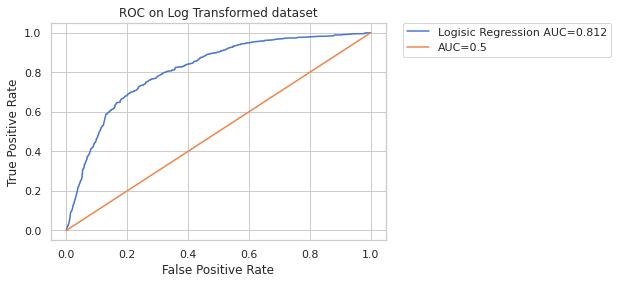

The log loss and auc was found to be 0.542 and 0.812 for Logisic Regression on Log Transformed dataset.


In [11]:
labels=[] #storing all labels
y_preds = [] #storing all y_pred
y_pred = model.predict_proba(X_val)[:,1]
label="Logisic Regression"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result
del result

In [12]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.541988,0.812369


# Decision Trees

In [ ]:
model = tree.DecisionTreeClassifier(class_weight='balanced')
params = { 
          'max_depth':[10,100,500,1000,-1], 
         'min_samples_split':[2,5,10,100,500], 
          'min_samples_leaf':[1,3,5,7,10],
          'max_leaf_nodes':[100,500,1000,5000,-1] 
          }


In [ ]:
%%time
find_best_params(model,params)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.9min finished


The best auc score was 0.786
The best params were: {'min_samples_split': 500, 'min_samples_leaf': 7, 'max_leaf_nodes': 5000, 'max_depth': 10}
CPU times: user 5.68 s, sys: 266 ms, total: 5.94 s
Wall time: 3min 59s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=5000,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [13]:
model = tree.DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=5000,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                        splitter='best')

model.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=5000,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [14]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=10,
                                                             max_features=None,
                                                             max_leaf_nodes=5000,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=7,
                                                             min_samples_split=500,
                                                             min_weight_fraction_leaf=0.0,
                                                             presort='deprecated',
         

		 Decision Tree Classifier on Log Transformed dataset 		 



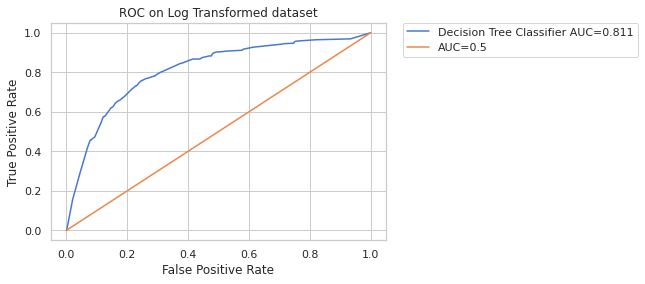

The log loss and auc was found to be 0.141 and 0.811 for Decision Tree Classifier on Log Transformed dataset.


In [15]:
i+=1
y_pred = cc_model.predict_proba(X_val)[:,1]
label="Decision Tree Classifier"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [16]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.541988,0.812369
1,Decision Tree Classifier,Log Transformed,0.140748,0.810504


# Random Forest

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5],
          'max_leaf_nodes':[100,250] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 80.1min finished


The best auc score was 0.817
The best params were: {'n_estimators': 2000, 'min_samples_split': 500, 'min_samples_leaf': 3, 'max_leaf_nodes': 250, 'max_depth': 500}
CPU times: user 7min 5s, sys: 927 ms, total: 7min 6s
Wall time: 1h 27min 13s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [17]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False,
                       verbose=0, warm_start=False)

%time model.fit(X_train,y_train)

CPU times: user 9min 4s, sys: 2.03 s, total: 9min 6s
Wall time: 4min 37s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [18]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=500,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=3,
                                                             min_samples_split=500,
                         

		 Random Forest Classifier on Log Transformed dataset 		 



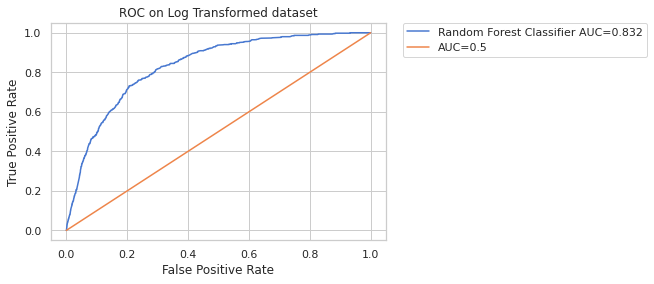

The log loss and auc was found to be 0.138 and 0.832 for Random Forest Classifier on Log Transformed dataset.


In [19]:
i+=1
y_pred = cc_model.predict_proba(X_val)[:,1]
label="Random Forest Classifier"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [20]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.541988,0.812369
1,Decision Tree Classifier,Log Transformed,0.140748,0.810504
2,Random Forest Classifier,Log Transformed,0.137583,0.832049


# Selecting top features

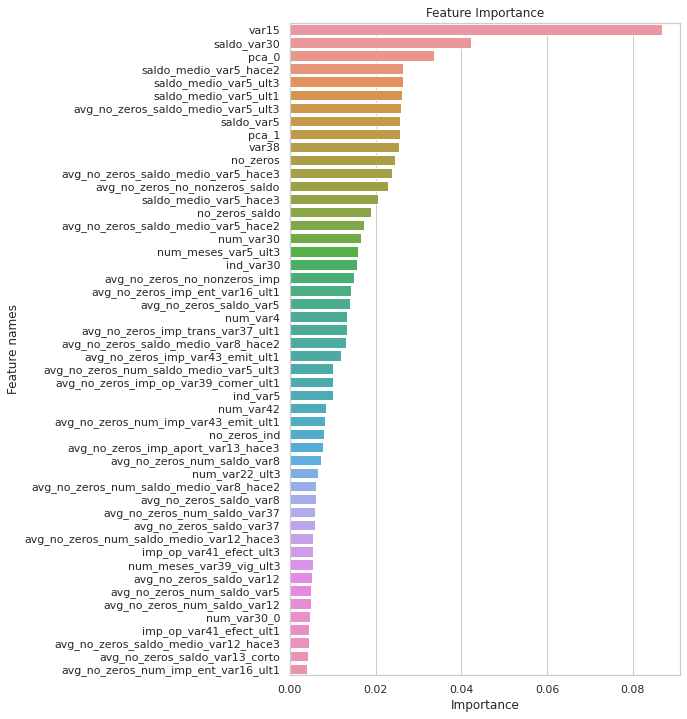

In [21]:
plot_feature_importance(X_train,model.feature_importances_,top=50,size=(7,12))

We will create new datasets with less features.

In [22]:
#getting features that have >=0.01 feature importance value.
top=0.01
features = get_top_features(X_train,model.feature_importances_,top=top)
print("There are %i features that have feature importance value above %.5f"%(len(features),top))
X_train_01 = X_train[features].copy()
X_val_01 = X_val[features].copy()
X_test_01 = X_val[features].copy()

There are 29 features that have feature importance value above 0.01000


In [23]:
#getting top k features
top=100
features = get_top_features(X_train,model.feature_importances_,top=top)
print("Taking top %i features"%(top))
X_train_100 = X_train[features].copy()
X_val_100 = X_val[features].copy()
X_test_100 = X_val[features].copy()

Taking top 100 features


In [24]:
#getting top k features
top=250
features = get_top_features(X_train,model.feature_importances_,top=top)
print("Taking top %i features"%(top))
X_train_200 = X_train[features].copy()
X_val_200 = X_val[features].copy()
X_test_200 = X_val[features].copy()

Taking top 250 features


# XGB Classifier

In [25]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = 0.9,
                      objective='binary:logistic', 
                      n_estimators=750,
                      reg_alpha = 0.2,
                      max_depth=6, 
                      gamma=0
                     )


In [26]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train,y_train,eval_set=[(X_val,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.791895	validation_0-error:0.039814
[1]	validation_0-auc:0.813718	validation_0-error:0.039726
[2]	validation_0-auc:0.809184	validation_0-error:0.039551
[3]	validation_0-auc:0.822006	validation_0-error:0.039551
[4]	validation_0-auc:0.818958	validation_0-error:0.039551
[5]	validation_0-auc:0.816855	validation_0-error:0.039551
[6]	validation_0-auc:0.818236	validation_0-error:0.039551
[7]	validation_0-auc:0.81776	validation_0-error:0.039551
[8]	validation_0-auc:0.818208	validation_0-error:0.039551
[9]	validation_0-auc:0.816619	validation_0-error:0.039551
[10]	validation_0-auc:0.817655	validation_0-error:0.039551
[11]	validation_0-auc:0.819069	validation_0-error:0.039551
[12]	validation_0-auc:0.818811	validation_0-error:0.039551
[13]	validation_0-auc:0.818158	validation_0-error:0.039551
[14]	validation_0-auc:0.817816	validation_0-error:0.039551
[15]	validation_0-auc:0.817742	validation_0-error:0.039551
[16]	validation_0-auc:0.819804	validation_0-error:0.039551
[17]	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=750, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0.2, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

		 XGBoost Classifer on Log Transformed dataset 		 



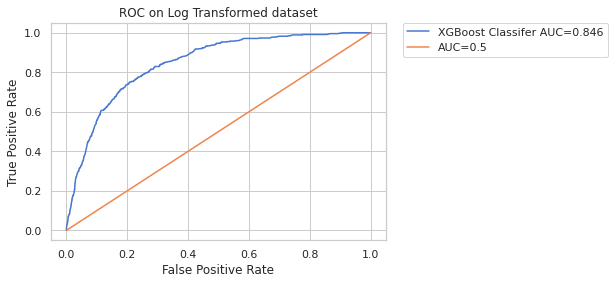

The log loss and auc was found to be 0.133 and 0.846 for XGBoost Classifer on Log Transformed dataset.


In [27]:
y_pred = model.predict_proba(X_val)[:,1]
label="XGBoost Classifer"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [28]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.541988,0.812369
1,Decision Tree Classifier,Log Transformed,0.140748,0.810504
2,Random Forest Classifier,Log Transformed,0.137583,0.832049
3,XGBoost Classifer,Log Transformed,0.133199,0.846218


# LightGBM Classifier

In [29]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = .5,
                      subsample = 0.7,
                      objective='binary', 
                      n_estimators=500,
                      reg_alpha = 0.3,
                      max_depth=8, 
                      gamma=0
                     )


In [30]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train,y_train,eval_set=[(X_val,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's binary_logloss: 0.165843	valid_0's auc: 0.787266
[2]	valid_0's binary_logloss: 0.165178	valid_0's auc: 0.818508
[3]	valid_0's binary_logloss: 0.164531	valid_0's auc: 0.823848
[4]	valid_0's binary_logloss: 0.163946	valid_0's auc: 0.824583
[5]	valid_0's binary_logloss: 0.163371	valid_0's auc: 0.822803
[6]	valid_0's binary_logloss: 0.162815	valid_0's auc: 0.822012
[7]	valid_0's binary_logloss: 0.162155	valid_0's auc: 0.82593
[8]	valid_0's binary_logloss: 0.161653	valid_0's auc: 0.825297
[9]	valid_0's binary_logloss: 0.16111	valid_0's auc: 0.826955
[10]	valid_0's binary_logloss: 0.160602	valid_0's auc: 0.827602
[11]	valid_0's binary_logloss: 0.160139	valid_0's auc: 0.826869
[12]	valid_0's binary_logloss: 0.159658	valid_0's auc: 0.827747
[13]	valid_0's binary_logloss: 0.159289	valid_0's auc: 0.826936
[14]	valid_0's binary_logloss: 0.158802	valid_0's auc: 0.82894
[15]	valid_0's binary_logloss: 0.158386	valid_0's auc: 0.827846
[16]	valid_0's binary_logloss: 0.157979	valid_0's au

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               gamma=0, importance_type='split', learning_rate=0.01,
               max_depth=8, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=500, n_jobs=-1, nthread=-1,
               num_leaves=31, objective='binary', random_state=None,
               reg_alpha=0.3, reg_lambda=0.0, scale_pos_weight=1, silent=True,
               subsample=0.7, subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer on Log Transformed dataset 		 



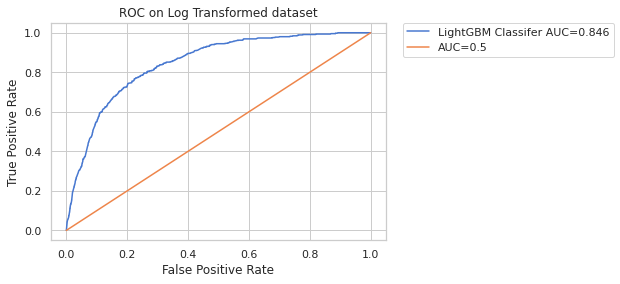

The log loss and auc was found to be 0.133 and 0.846 for LightGBM Classifer on Log Transformed dataset.


In [31]:
y_pred = model.predict_proba(X_val)[:,1]
label="LightGBM Classifer"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [32]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.541988,0.812369
1,Decision Tree Classifier,Log Transformed,0.140748,0.810504
2,Random Forest Classifier,Log Transformed,0.137583,0.832049
3,XGBoost Classifer,Log Transformed,0.133199,0.846218
4,LightGBM Classifer,Log Transformed,0.133179,0.845647


# Random Forest (feature importance>0.01)

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5],
          'max_leaf_nodes':[100,250] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3,X_train=X_train_01)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 40.0min finished


The best auc score was 0.821
The best params were: {'n_estimators': 1000, 'min_samples_split': 500, 'min_samples_leaf': 3, 'max_leaf_nodes': 250, 'max_depth': 500}
CPU times: user 1min 47s, sys: 343 ms, total: 1min 47s
Wall time: 41min 49s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [33]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False,
                       verbose=0, warm_start=False)

model.fit(X_train_01,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [34]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train_01,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=500,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=3,
                                                             min_samples_split=500,
                         

		 Random Forest Classifier (feature importance>0.01) on Log Transformed dataset 		 



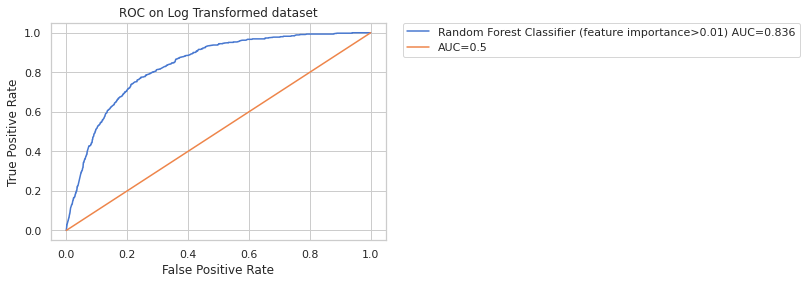

The log loss and auc was found to be 0.137 and 0.836 for Random Forest Classifier (feature importance>0.01) on Log Transformed dataset.


In [35]:
i+=1
y_pred = cc_model.predict_proba(X_val_01)[:,1]
label="Random Forest Classifier (feature importance>0.01)"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [36]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.541988,0.812369
1,Decision Tree Classifier,Log Transformed,0.140748,0.810504
2,Random Forest Classifier,Log Transformed,0.137583,0.832049
3,XGBoost Classifer,Log Transformed,0.133199,0.846218
4,LightGBM Classifer,Log Transformed,0.133179,0.845647
5,Random Forest Classifier (feature importance>0...,Log Transformed,0.136757,0.835733


# XGB Classifier (feature importance>0.01)

In [37]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.7,
                      subsample = 0.9,
                      objective='binary:logistic', 
                      n_estimators=1000,
                      reg_alpha = 0.2,
                      max_depth=4, 
                      gamma=0.0
                     )


In [38]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_01,y_train,eval_set=[(X_val_01,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.777621	validation_0-error:0.039551
[1]	validation_0-auc:0.783507	validation_0-error:0.039551
[2]	validation_0-auc:0.805954	validation_0-error:0.039551
[3]	validation_0-auc:0.809355	validation_0-error:0.039551
[4]	validation_0-auc:0.813469	validation_0-error:0.039551
[5]	validation_0-auc:0.815233	validation_0-error:0.039551
[6]	validation_0-auc:0.814986	validation_0-error:0.039551
[7]	validation_0-auc:0.816345	validation_0-error:0.039551
[8]	validation_0-auc:0.818301	validation_0-error:0.039551
[9]	validation_0-auc:0.819003	validation_0-error:0.039551
[10]	validation_0-auc:0.819497	validation_0-error:0.039551
[11]	validation_0-auc:0.820535	validation_0-error:0.039551
[12]	validation_0-auc:0.820478	validation_0-error:0.039551
[13]	validation_0-auc:0.820235	validation_0-error:0.039551
[14]	validation_0-auc:0.820646	validation_0-error:0.039551
[15]	validation_0-auc:0.820024	validation_0-error:0.039551
[16]	validation_0-auc:0.821014	validation_0-error:0.039551
[17]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0.2, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

		 XGBoost Classifer(feature importance>0.01) on Log Transformed dataset 		 



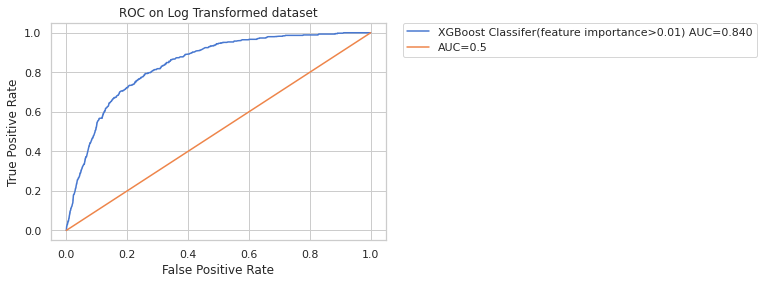

The log loss and auc was found to be 0.135 and 0.840 for XGBoost Classifer(feature importance>0.01) on Log Transformed dataset.


In [39]:
y_pred = model.predict_proba(X_val_01)[:,1]
label="XGBoost Classifer(feature importance>0.01)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [40]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.541988,0.812369
1,Decision Tree Classifier,Log Transformed,0.140748,0.810504
2,Random Forest Classifier,Log Transformed,0.137583,0.832049
3,XGBoost Classifer,Log Transformed,0.133199,0.846218
4,LightGBM Classifer,Log Transformed,0.133179,0.845647
5,Random Forest Classifier (feature importance>0...,Log Transformed,0.136757,0.835733
6,XGBoost Classifer(feature importance>0.01),Log Transformed,0.134690,0.840319


# LightGBM Classifier (feature importance>0.01)

In [41]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.8,
                      subsample = 0.7,
                      objective='binary', 
                      n_estimators=574,
                      reg_alpha = 0.,
                      max_depth=6,
                     )


In [42]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_01,y_train,eval_set=[(X_val_01,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's binary_logloss: 0.16575	valid_0's auc: 0.817831
[2]	valid_0's binary_logloss: 0.165024	valid_0's auc: 0.818609
[3]	valid_0's binary_logloss: 0.164314	valid_0's auc: 0.825957
[4]	valid_0's binary_logloss: 0.163628	valid_0's auc: 0.827618
[5]	valid_0's binary_logloss: 0.163051	valid_0's auc: 0.828154
[6]	valid_0's binary_logloss: 0.162446	valid_0's auc: 0.827404
[7]	valid_0's binary_logloss: 0.161853	valid_0's auc: 0.827458
[8]	valid_0's binary_logloss: 0.161282	valid_0's auc: 0.827682
[9]	valid_0's binary_logloss: 0.160728	valid_0's auc: 0.827594
[10]	valid_0's binary_logloss: 0.160202	valid_0's auc: 0.828026
[11]	valid_0's binary_logloss: 0.15967	valid_0's auc: 0.82849
[12]	valid_0's binary_logloss: 0.15924	valid_0's auc: 0.828319
[13]	valid_0's binary_logloss: 0.158763	valid_0's auc: 0.828297
[14]	valid_0's binary_logloss: 0.158332	valid_0's auc: 0.828607
[15]	valid_0's binary_logloss: 0.157904	valid_0's auc: 0.828572
[16]	valid_0's binary_logloss: 0.157462	valid_0's auc

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
               importance_type='split', learning_rate=0.01, max_depth=6,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=574, n_jobs=-1, nthread=-1, num_leaves=31,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, scale_pos_weight=1, silent=True, subsample=0.7,
               subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer (feature importance>0.01) on Log Transformed dataset 		 



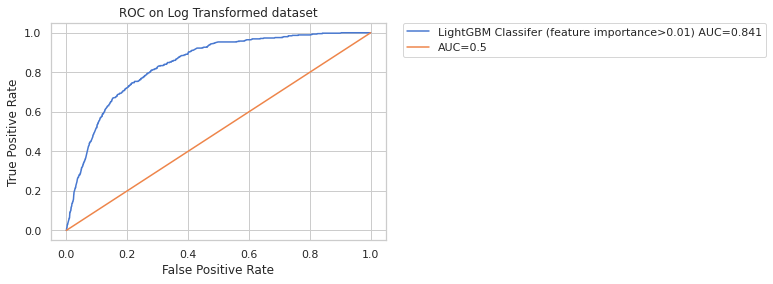

The log loss and auc was found to be 0.135 and 0.841 for LightGBM Classifer (feature importance>0.01) on Log Transformed dataset.


In [43]:
y_pred = model.predict_proba(X_val_01)[:,1]
label="LightGBM Classifer (feature importance>0.01)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [44]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.541988,0.812369
1,Decision Tree Classifier,Log Transformed,0.140748,0.810504
2,Random Forest Classifier,Log Transformed,0.137583,0.832049
3,XGBoost Classifer,Log Transformed,0.133199,0.846218
4,LightGBM Classifer,Log Transformed,0.133179,0.845647
5,Random Forest Classifier (feature importance>0...,Log Transformed,0.136757,0.835733
6,XGBoost Classifer(feature importance>0.01),Log Transformed,0.134690,0.840319
7,LightGBM Classifer (feature importance>0.01),Log Transformed,0.134618,0.841348


# Random Forest (top 100)

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5],
          'max_leaf_nodes':[100,250] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3,X_train=X_train_100)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 53.1min finished


The best auc score was 0.822
The best params were: {'n_estimators': 1000, 'min_samples_split': 500, 'min_samples_leaf': 5, 'max_leaf_nodes': 250, 'max_depth': 500}
CPU times: user 2min 32s, sys: 634 ms, total: 2min 32s
Wall time: 55min 40s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [45]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False,
                       verbose=0, warm_start=False)

model.fit(X_train_100,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [46]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train_100,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=500,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=5,
                                                             min_samples_split=500,
                         

		 Random Forest Classifier (top 100) on Log Transformed dataset 		 



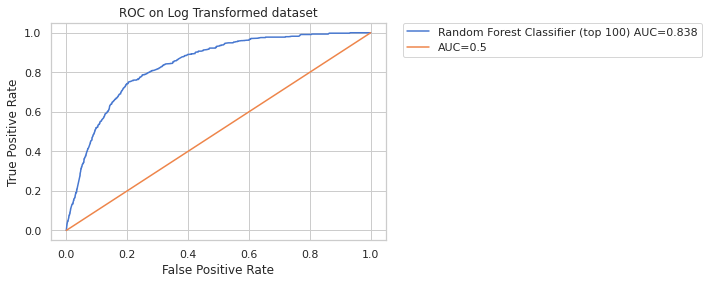

The log loss and auc was found to be 0.136 and 0.838 for Random Forest Classifier (top 100) on Log Transformed dataset.


In [47]:
i+=1
y_pred = cc_model.predict_proba(X_val_100)[:,1]
label="Random Forest Classifier (top 100)"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [48]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.541988,0.812369
1,Decision Tree Classifier,Log Transformed,0.140748,0.810504
2,Random Forest Classifier,Log Transformed,0.137583,0.832049
3,XGBoost Classifer,Log Transformed,0.133199,0.846218
4,LightGBM Classifer,Log Transformed,0.133179,0.845647
5,Random Forest Classifier (feature importance>0...,Log Transformed,0.136757,0.835733
6,XGBoost Classifer(feature importance>0.01),Log Transformed,0.134690,0.840319
7,LightGBM Classifer (feature importance>0.01),Log Transformed,0.134618,0.841348
8,Random Forest Classifier (top 100),Log Transformed,0.136038,0.837843


# XGB Classifier (top 100)

In [49]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.6,
                      subsample = 1,
                      objective='binary:logistic', 
                      n_estimators=845,
                      reg_alpha = 0.3,
                      max_depth=5,
                     )

In [50]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_100,y_train,eval_set=[(X_val_100,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.806602	validation_0-error:0.039551
[1]	validation_0-auc:0.805924	validation_0-error:0.039551
[2]	validation_0-auc:0.817736	validation_0-error:0.039551
[3]	validation_0-auc:0.8174	validation_0-error:0.039551
[4]	validation_0-auc:0.820702	validation_0-error:0.039551
[5]	validation_0-auc:0.825147	validation_0-error:0.039551
[6]	validation_0-auc:0.824939	validation_0-error:0.039551
[7]	validation_0-auc:0.825745	validation_0-error:0.039551
[8]	validation_0-auc:0.825999	validation_0-error:0.039551
[9]	validation_0-auc:0.82525	validation_0-error:0.039551
[10]	validation_0-auc:0.822821	validation_0-error:0.039551
[11]	validation_0-auc:0.822319	validation_0-error:0.039551
[12]	validation_0-auc:0.822503	validation_0-error:0.039551
[13]	validation_0-auc:0.822556	validation_0-error:0.039551
[14]	validation_0-auc:0.823177	validation_0-error:0.039551
[15]	validation_0-auc:0.821823	validation_0-error:0.039551
[16]	validation_0-auc:0.821394	validation_0-error:0.039551
[17]	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=845, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

		 XGBoost Classifer(top 100) on Log Transformed dataset 		 



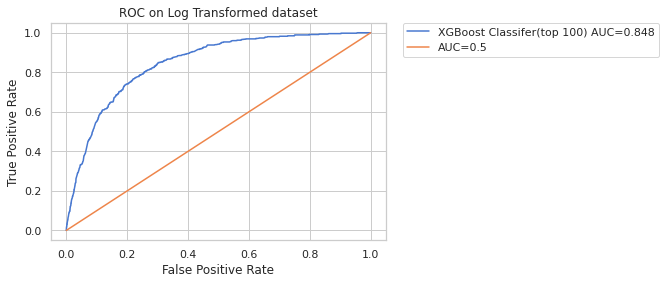

The log loss and auc was found to be 0.133 and 0.848 for XGBoost Classifer(top 100) on Log Transformed dataset.


In [51]:
y_pred = model.predict_proba(X_val_100)[:,1]
label="XGBoost Classifer(top 100)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [52]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.541988,0.812369
1,Decision Tree Classifier,Log Transformed,0.140748,0.810504
2,Random Forest Classifier,Log Transformed,0.137583,0.832049
3,XGBoost Classifer,Log Transformed,0.133199,0.846218
4,LightGBM Classifer,Log Transformed,0.133179,0.845647
5,Random Forest Classifier (feature importance>0...,Log Transformed,0.136757,0.835733
6,XGBoost Classifer(feature importance>0.01),Log Transformed,0.134690,0.840319
7,LightGBM Classifer (feature importance>0.01),Log Transformed,0.134618,0.841348
8,Random Forest Classifier (top 100),Log Transformed,0.136038,0.837843
9,XGBoost Classifer(top 100),Log Transformed,0.132800,0.847782


# LightGBM Classifier (top 100)

In [53]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = 1,
                      objective='binary', 
                      n_estimators=947,
                      reg_alpha = 0.4,
                      max_depth=5)


In [54]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_100,y_train,eval_set=[(X_val_100,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's binary_logloss: 0.165882	valid_0's auc: 0.792025
[2]	valid_0's binary_logloss: 0.165297	valid_0's auc: 0.810325
[3]	valid_0's binary_logloss: 0.164712	valid_0's auc: 0.807416
[4]	valid_0's binary_logloss: 0.164097	valid_0's auc: 0.821195
[5]	valid_0's binary_logloss: 0.163531	valid_0's auc: 0.82214
[6]	valid_0's binary_logloss: 0.16299	valid_0's auc: 0.823578
[7]	valid_0's binary_logloss: 0.162437	valid_0's auc: 0.826276
[8]	valid_0's binary_logloss: 0.161968	valid_0's auc: 0.82411
[9]	valid_0's binary_logloss: 0.161445	valid_0's auc: 0.822834
[10]	valid_0's binary_logloss: 0.160997	valid_0's auc: 0.822177
[11]	valid_0's binary_logloss: 0.160585	valid_0's auc: 0.821832
[12]	valid_0's binary_logloss: 0.160125	valid_0's auc: 0.822098
[13]	valid_0's binary_logloss: 0.159645	valid_0's auc: 0.82262
[14]	valid_0's binary_logloss: 0.15924	valid_0's auc: 0.822436
[15]	valid_0's binary_logloss: 0.158823	valid_0's auc: 0.822385
[16]	valid_0's binary_logloss: 0.158479	valid_0's auc:

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               importance_type='split', learning_rate=0.01, max_depth=5,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=947, n_jobs=-1, nthread=-1, num_leaves=31,
               objective='binary', random_state=None, reg_alpha=0.4,
               reg_lambda=0.0, scale_pos_weight=1, silent=True, subsample=1,
               subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer(top 100) on Log Transformed dataset 		 



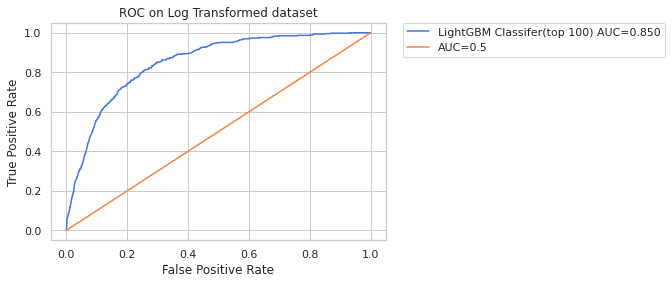

The log loss and auc was found to be 0.132 and 0.850 for LightGBM Classifer(top 100) on Log Transformed dataset.


In [55]:
y_pred = model.predict_proba(X_val_100)[:,1]
label="LightGBM Classifer(top 100)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [56]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.541988,0.812369
1,Decision Tree Classifier,Log Transformed,0.140748,0.810504
2,Random Forest Classifier,Log Transformed,0.137583,0.832049
3,XGBoost Classifer,Log Transformed,0.133199,0.846218
4,LightGBM Classifer,Log Transformed,0.133179,0.845647
5,Random Forest Classifier (feature importance>0...,Log Transformed,0.136757,0.835733
6,XGBoost Classifer(feature importance>0.01),Log Transformed,0.134690,0.840319
7,LightGBM Classifer (feature importance>0.01),Log Transformed,0.134618,0.841348
8,Random Forest Classifier (top 100),Log Transformed,0.136038,0.837843
9,XGBoost Classifer(top 100),Log Transformed,0.132800,0.847782


# Random Forest (top 250)

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5],
          'max_leaf_nodes':[100,250] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3,X_train=X_train_200)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 70.1min finished


The best auc score was 0.818
The best params were: {'n_estimators': 2000, 'min_samples_split': 500, 'min_samples_leaf': 3, 'max_leaf_nodes': 250, 'max_depth': 500}
CPU times: user 6min 5s, sys: 2.21 s, total: 6min 7s
Wall time: 1h 16min 10s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [57]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False,
                       verbose=0, warm_start=False)
model.fit(X_train_200,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [58]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train_200,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=500,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=3,
                                                             min_samples_split=500,
                         

		 Random Forest Classifier (top 250) on Log Transformed dataset 		 



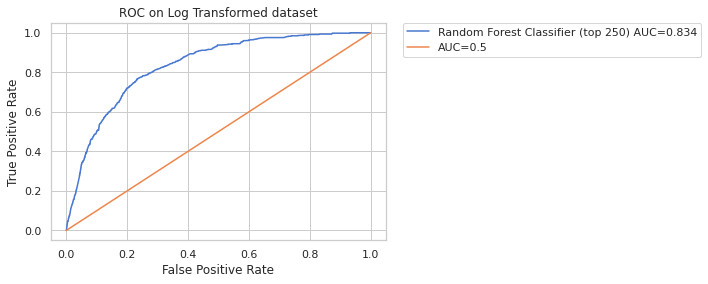

The log loss and auc was found to be 0.137 and 0.834 for Random Forest Classifier (top 250) on Log Transformed dataset.


In [59]:
i+=1
y_pred = cc_model.predict_proba(X_val_200)[:,1]
label="Random Forest Classifier (top 250)"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [60]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.541988,0.812369
1,Decision Tree Classifier,Log Transformed,0.140748,0.810504
2,Random Forest Classifier,Log Transformed,0.137583,0.832049
3,XGBoost Classifer,Log Transformed,0.133199,0.846218
4,LightGBM Classifer,Log Transformed,0.133179,0.845647
5,Random Forest Classifier (feature importance>0...,Log Transformed,0.136757,0.835733
6,XGBoost Classifer(feature importance>0.01),Log Transformed,0.134690,0.840319
7,LightGBM Classifer (feature importance>0.01),Log Transformed,0.134618,0.841348
8,Random Forest Classifier (top 100),Log Transformed,0.136038,0.837843
9,XGBoost Classifer(top 100),Log Transformed,0.132800,0.847782


# XGB Classifier (top 250)

In [61]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.8, 
                      subsample = 0.7,
                      objective='binary:logistic', 
                      n_estimators=845,
                      reg_alpha = 0.3,
                      max_depth=7,
                      gamma=0,
                     )

In [62]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_200,y_train,eval_set=[(X_val_200,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.773369	validation_0-error:0.040954
[1]	validation_0-auc:0.795843	validation_0-error:0.039639
[2]	validation_0-auc:0.8162	validation_0-error:0.039463
[3]	validation_0-auc:0.81989	validation_0-error:0.039551
[4]	validation_0-auc:0.81826	validation_0-error:0.039551
[5]	validation_0-auc:0.820687	validation_0-error:0.039551
[6]	validation_0-auc:0.822701	validation_0-error:0.039551
[7]	validation_0-auc:0.826561	validation_0-error:0.039551
[8]	validation_0-auc:0.82633	validation_0-error:0.039551
[9]	validation_0-auc:0.828032	validation_0-error:0.039551
[10]	validation_0-auc:0.827837	validation_0-error:0.039551
[11]	validation_0-auc:0.828592	validation_0-error:0.039551
[12]	validation_0-auc:0.829706	validation_0-error:0.039551
[13]	validation_0-auc:0.830036	validation_0-error:0.039551
[14]	validation_0-auc:0.829732	validation_0-error:0.039551
[15]	validation_0-auc:0.829358	validation_0-error:0.039551
[16]	validation_0-auc:0.830803	validation_0-error:0.039551
[17]	validat

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=845, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)

		 XGBoost Classifer(top 250) on Log Transformed dataset 		 



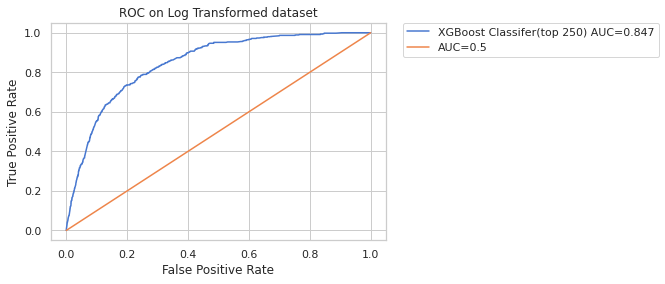

The log loss and auc was found to be 0.133 and 0.847 for XGBoost Classifer(top 250) on Log Transformed dataset.


In [63]:
y_pred = model.predict_proba(X_val_200)[:,1]
label="XGBoost Classifer(top 250)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [64]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.541988,0.812369
1,Decision Tree Classifier,Log Transformed,0.140748,0.810504
2,Random Forest Classifier,Log Transformed,0.137583,0.832049
3,XGBoost Classifer,Log Transformed,0.133199,0.846218
4,LightGBM Classifer,Log Transformed,0.133179,0.845647
5,Random Forest Classifier (feature importance>0...,Log Transformed,0.136757,0.835733
6,XGBoost Classifer(feature importance>0.01),Log Transformed,0.134690,0.840319
7,LightGBM Classifer (feature importance>0.01),Log Transformed,0.134618,0.841348
8,Random Forest Classifier (top 100),Log Transformed,0.136038,0.837843
9,XGBoost Classifer(top 100),Log Transformed,0.132800,0.847782


# LightGBM Classifier (top 250)

In [79]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = 0.9,
                      objective='binary', 
                      n_estimators=447,
                      reg_alpha = 0,
                      max_depth=6,
                     )
#valid_0's auc: 0.846464

In [80]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_200,y_train,eval_set=[(X_val_200,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's binary_logloss: 0.16585	valid_0's auc: 0.799833
[2]	valid_0's binary_logloss: 0.165139	valid_0's auc: 0.821951
[3]	valid_0's binary_logloss: 0.164517	valid_0's auc: 0.820339
[4]	valid_0's binary_logloss: 0.16393	valid_0's auc: 0.824593
[5]	valid_0's binary_logloss: 0.163373	valid_0's auc: 0.82488
[6]	valid_0's binary_logloss: 0.162856	valid_0's auc: 0.822198
[7]	valid_0's binary_logloss: 0.162379	valid_0's auc: 0.821838
[8]	valid_0's binary_logloss: 0.16181	valid_0's auc: 0.825397
[9]	valid_0's binary_logloss: 0.161316	valid_0's auc: 0.827194
[10]	valid_0's binary_logloss: 0.160841	valid_0's auc: 0.827136
[11]	valid_0's binary_logloss: 0.160383	valid_0's auc: 0.82755
[12]	valid_0's binary_logloss: 0.159905	valid_0's auc: 0.827672
[13]	valid_0's binary_logloss: 0.159396	valid_0's auc: 0.829828
[14]	valid_0's binary_logloss: 0.158916	valid_0's auc: 0.831546
[15]	valid_0's binary_logloss: 0.158407	valid_0's auc: 0.832445
[16]	valid_0's binary_logloss: 0.157944	valid_0's auc:

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               importance_type='split', learning_rate=0.01, max_depth=6,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=447, n_jobs=-1, nthread=-1, num_leaves=31,
               objective='binary', random_state=None, reg_alpha=0,
               reg_lambda=0.0, scale_pos_weight=1, silent=True, subsample=0.9,
               subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer(top 250) on Log Transformed dataset 		 



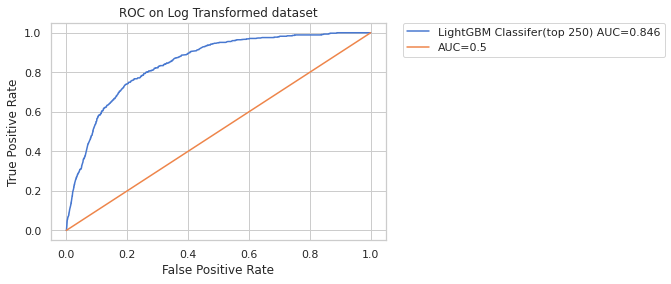

The log loss and auc was found to be 0.133 and 0.846 for LightGBM Classifer(top 250) on Log Transformed dataset.


In [81]:
y_pred = model.predict_proba(X_val_200)[:,1]
label="LightGBM Classifer(top 250)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

# Combined

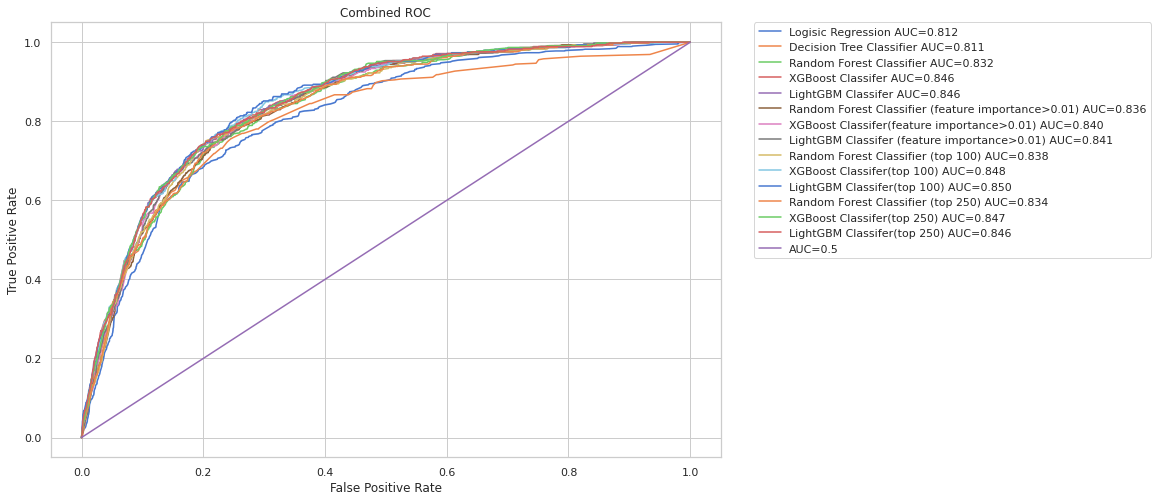

In [82]:
plot_auc(y_val,y_preds,labels)

In [84]:
result_df.sort_values(by='auc',ascending=False)

,Model,Dataset,log_loss,auc
10,LightGBM Classifer(top 100),Log Transformed,0.132069,0.849751
9,XGBoost Classifer(top 100),Log Transformed,0.132800,0.847782
12,XGBoost Classifer(top 250),Log Transformed,0.132901,0.846613
13,LightGBM Classifer(top 250),Log Transformed,0.133177,0.846464
3,XGBoost Classifer,Log Transformed,0.133199,0.846218
4,LightGBM Classifer,Log Transformed,0.133179,0.845647
7,LightGBM Classifer (feature importance>0.01),Log Transformed,0.134618,0.841348
6,XGBoost Classifer(feature importance>0.01),Log Transformed,0.134690,0.840319
8,Random Forest Classifier (top 100),Log Transformed,0.136038,0.837843
5,Random Forest Classifier (feature importance>0...,Log Transformed,0.136757,0.835733
